<a href="https://colab.research.google.com/github/PashaIanko/CIFAR10Recognition/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
# Handling dataset
import torch.utils.data as data
# Torchvision library
import torchvision

import matplotlib.pyplot as plt
import random
import numpy as np
import copy
import time
import os
import cv2
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [11]:
from sklearn.model_selection import train_test_split

# Helper functions

In [4]:
def report(arrs_):
    for arr_ in arrs_:
        print(np.min(arr_), np.max(arr_))

In [5]:
# def set_seed(seed, use_gpu = True):
#     """
#     Set SEED for PyTorch reproducibility
#     """
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     if use_gpu:
#         torch.cuda.manual_seed_all(seed)
#         torch.cuda.manual_seed(seed)
#         torch.backends.cudnn.deterministic = True
#         torch.backends.cudnn.benchmark = False

# SEED = 44

# USE_SEED = True

# if USE_SEED:
#     set_seed(SEED, torch.cuda.is_available())

In [6]:
def get_subsample(X_, Y_, percentage_):
    X_sub, _, Y_sub, _ = \
        train_test_split(
            X_,
            Y_,
            train_size=percentage_,
            random_state=42,
            stratify=Y_
        )
    return X_sub, Y_sub

In [7]:
def flatten(arr_):
    assert len(arr_.shape) == 4
    return arr_.reshape(
        arr_.shape[0],
        arr_.shape[1] * arr_.shape[2] * arr_.shape[3]
    )


def reshape_back_to_images(arr_):
    return arr_.reshape(arr_.shape[0], 32, 32, 3)

# Download the data

In [12]:
ROOT = './data'
train_data = torchvision.datasets.CIFAR10(
    root=ROOT,
    train=True,
    download=True
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [13]:
test_data = torchvision.datasets.CIFAR10(
    root=ROOT,
    train=False,
    download=True,
    # transform=test_transforms
)

Files already downloaded and verified


In [14]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [15]:
train_data.data.shape, type(train_data.data)

((50000, 32, 32, 3), numpy.ndarray)

In [16]:
test_data.data.shape

(10000, 32, 32, 3)

# Data exploration

Text(0.5, 1.0, 'Label: truck')

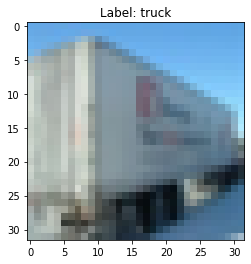

In [11]:
img_idx = 15
_, ax = plt.subplots()

img = train_data[img_idx][0]
label = train_data[img_idx][1]
ax.imshow(img)

ax.set_title(
    f'Label: {classes[label]}'
)

In [ ]:
np.min(train_data.data), np.max(train_data.data)

(0, 255)

In [ ]:
train_mean = train_data.data.mean(axis=(0,1,2)) / 255
train_std = train_data.data.std(axis=(0,1,2)) / 255

print("-----  TRAIN NORMALIZATION VALUES  -----")
print(f"Mean: {train_mean}")
print(f"Standard Deviation: {train_std}")

-----  TRAIN NORMALIZATION VALUES  -----
Mean: [0.49139968 0.48215841 0.44653091]
Standard Deviation: [0.24703223 0.24348513 0.26158784]


# Data split

In [17]:
TRAIN_PERCENTAGE = 0.9
VAL_PERCENTAGE = 0.1
RANDOM_STATE = 42
assert TRAIN_PERCENTAGE + VAL_PERCENTAGE == 1.0

N_TRAIN_EXAMPLES = int(len(train_data) * TRAIN_PERCENTAGE)
N_VALIDATION_EXAMPLES = len(train_data) - N_TRAIN_EXAMPLES

In [18]:
train_labels = np.array([train_data[i][1] for i in range(len(train_data))])

In [19]:
assert len(np.unique(train_labels)) == 10
train_labels.shape, train_data.data.shape

((50000,), (50000, 32, 32, 3))

In [20]:
X_test = test_data.data
Y_test = np.array([test_data[i][1] for i in range(len(test_data))])
Y_test.shape, X_test.shape

((10000,), (10000, 32, 32, 3))

In [21]:
X_train, X_validation, Y_train, Y_validation = \
    train_test_split(
        train_data.data,
        train_labels,
        train_size=TRAIN_PERCENTAGE,
        random_state=42,
        stratify=train_labels
    )

In [22]:
X_train.shape, X_validation.shape, Y_train.shape, Y_validation.shape

((45000, 32, 32, 3), (5000, 32, 32, 3), (45000,), (5000,))

# Data preprocessing

In [18]:
from sklearn.preprocessing import StandardScaler

In [21]:
scaler = StandardScaler()

In [22]:
X_train = reshape_back_to_images(
    scaler.fit_transform(flatten(X_train)))

X_validation = reshape_back_to_images(
    scaler.transform(flatten(X_validation)))

X_test = reshape_back_to_images(
    scaler.transform(flatten(X_test)))

In [23]:
assert len(np.unique(Y_train)) == 10
assert len(np.unique(Y_validation)) == 10
assert len(np.unique(Y_test)) == 10

In [27]:
def check_data(arrs_):
    for arr_ in arrs_:
        assert np.max(arr_) <= 3 and np.min(arr_) >= -3

check_data([X_train, X_validation, X_test])

In [28]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
Y_train = encoder.fit_transform(Y_train.reshape(-1, 1)).toarray()
Y_validation = encoder.transform(Y_validation.reshape(-1, 1)).toarray()
Y_test = encoder.transform(Y_test.reshape(-1, 1)).toarray()

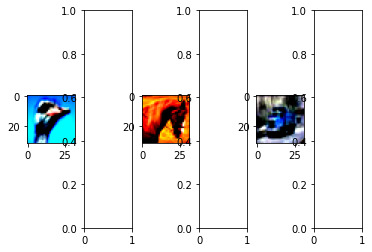

In [29]:
idx = 172
_, ax = plt.subplots(1, 6)
ax[0].imshow(X_train[idx])
# ax[1].imshow(train_data[idx][0])

ax[2].imshow(X_validation[idx])
#ax[3].imshow(X_validation_scaled[idx])

ax[4].imshow(X_test[idx])
# ax[5].imshow(X_test_scaled[idx])

In [30]:
X_train_subsample, Y_train_subsample = \
    get_subsample(X_train, Y_train, 0.3)

check_data([X_train_subsample])

X_train_subsample.shape, Y_train_subsample.shape

((13500, 32, 32, 3), (13500, 10))

In [31]:
X_validation_subsample, Y_validation_subsample = \
    get_subsample(X_validation, Y_validation, 0.3)

check_data([X_validation_subsample])

X_validation_subsample.shape, Y_validation_subsample.shape

((1500, 32, 32, 3), (1500, 10))

# Baseline

In [ ]:
from tensorflow.keras.models import Sequential

In [ ]:
from tensorflow.keras.layers import (
    Input,
    Dense,
    Conv2D,
    MaxPool2D,
    Dropout,
    BatchNormalization,
    Flatten
)
from functools import partial

In [ ]:
conv_layer = partial(
    Conv2D,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_size=(3, 3)
)

In [101]:
baseline_cnn = Sequential(
    [
        Input(shape=(32, 32, 3)),

        conv_layer(filters=32),
        conv_layer(filters=64),
        MaxPool2D(pool_size=(2, 2)),
     
        conv_layer(filters=128),
        MaxPool2D(pool_size=(2, 2)),
     
        conv_layer(filters=256),
        conv_layer(filters=256),
        MaxPool2D(pool_size=(2, 2)),
     
        Flatten(),
        # Dropout(0.2),
        Dense(300, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.2),
        Dense(100, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ]
)

NameError: ignored

In [102]:
baseline_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

NameError: ignored

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

history = baseline_cnn.fit(
    X_train_subsample,
    Y_train_subsample,
    validation_data=(X_validation_subsample, Y_validation_subsample),
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=3
        )
    ]
)

Epoch 1/20
422/422 [==============================] - 137s 322ms/step - loss: 1.9062 - accuracy: 0.3042 - val_loss: 1.5063 - val_accuracy: 0.4527
Epoch 2/20
422/422 [==============================] - 124s 294ms/step - loss: 1.4469 - accuracy: 0.4802 - val_loss: 1.3317 - val_accuracy: 0.5247
Epoch 3/20
306/422 [====================>.........] - ETA: 34s - loss: 1.2340 - accuracy: 0.5632

# Transfer learning resnet 50

## Data preprocessing

In [23]:
report([train_data.data])
train_data.data.shape

0 255


(50000, 32, 32, 3)

In [24]:
from tensorflow.keras.applications.resnet50 import \
    preprocess_input as resnet_preprocess

train_data_resnet = resnet_preprocess(train_data.data)
test_data_resnet = resnet_preprocess(test_data.data)

In [25]:
train_labels_resnet = np.array([item[1] for item in train_data])
print(np.unique(train_labels_resnet))

[0 1 2 3 4 5 6 7 8 9]


In [26]:
test_labels_resnet = np.array([item[1] for item in test_data])

In [27]:
train_data_resnet.shape, train_labels_resnet.shape

((50000, 32, 32, 3), (50000,))

In [28]:
X_train_resnet, X_validation_resnet, Y_train_resnet, Y_validation_resnet = \
    train_test_split(
        train_data_resnet,
        train_labels_resnet,
        train_size=TRAIN_PERCENTAGE,
        random_state=42,
        stratify=train_labels_resnet
    )

In [29]:
report(
    [X_train_resnet, X_validation_resnet, test_data_resnet]
)

-123.68 151.061
-123.68 151.061
-123.68 151.061


In [30]:
SUBSAMPLE_PERCENTAGE = 0.1

X_train_subsample, _, Y_train_subsample, _ = \
    train_test_split(
        train_data_resnet,
        train_labels_resnet,
        train_size=SUBSAMPLE_PERCENTAGE,
        random_state=42,
        stratify=train_labels_resnet
    )

_, X_validation_subsample, _, Y_validation_subsample = \
    train_test_split(
        train_data_resnet,
        train_labels_resnet,
        train_size=SUBSAMPLE_PERCENTAGE,
        random_state=42,
        stratify=train_labels_resnet
    )


## Building and running model

In [31]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Flatten,
    Dense,
    Dropout
)


resnet = Sequential()
resnet.add(
    ResNet50(
        include_top=False,
        input_shape=(32, 32, 3),
        weights='imagenet',
        pooling='avg'
    )
)
resnet.add(Flatten())
resnet.add(Dropout(0.2))
resnet.add(Dense(units=300, activation='relu'))
resnet.add(Dropout(0.2))
resnet.add(Dense(units=200, activation='relu'))
resnet.add(Dropout(0.2))
# resnet.add(Dense(units=100, activation='relu'))
# resnet.add()
resnet.add(Dense(units=10, activation='softmax'))

94765736/94765736 [==============================] - 0s 0us/step


In [32]:
resnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

In [33]:
X_train_subsample.shape, X_validation_subsample.shape, Y_train_subsample.shape

((5000, 32, 32, 3), (45000, 32, 32, 3), (5000,))

In [ ]:
history = resnet.fit(
    X_train_resnet,  # X_train_subsample,
    Y_train_resnet.reshape(-1, 1),  # Y_train_subsample.reshape(-1, 1),
    # validation_data=(
        # X_validation_subsample, Y_validation_subsample.reshape(-1, 1)),
    validation_data=(
        X_validation_resnet, Y_validation_resnet
    ),
    batch_size=32,
    epochs=3,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=3
        )
    ]
)

Epoch 1/3
1406/1407 [============================>.] - ETA: 0s - loss: 1.4826 - accuracy: 0.4808

# Plans
- Full dataset
- ResNet
- Data augmentation
- Hyperparameter fine-tuning
- Pretrained networks